In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open("../output_preprocessing/positive.pkl", "rb") as f:   # rb = read-binary
    positive = pickle.load(f)

with open("../output_preprocessing/negative.pkl", "rb") as f:   # rb = read-binary
    negative = pickle.load(f)

len(positive)
len(positive)


21831

In [83]:
processed_data = positive+negative
labels = np.array(len(positive)*[1]+len(negative)*[0])

Cross-validation accuracies: [0.86204901 0.86745128 0.87729114 0.86453107 0.87649556 0.87340795
 0.87032034 0.87205712 0.87147819 0.87032034]
Mean accuracy: 0.8705 ± 0.0046

=== Default Cutoff (0.5) ===
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      5999
           1       0.82      0.88      0.85      4366

    accuracy                           0.87     10365
   macro avg       0.86      0.87      0.87     10365
weighted avg       0.87      0.87      0.87     10365

Confusion Matrix:
[[5159  840]
 [ 526 3840]]
ROC AUC Score: 0.9388

=== Custom Cutoff (0.4) ===
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.88      5999
           1       0.80      0.90      0.85      4366

    accuracy                           0.86     10365
   macro avg       0.86      0.87      0.86     10365
weighted avg       0.87      0.86      0.86     10365

C

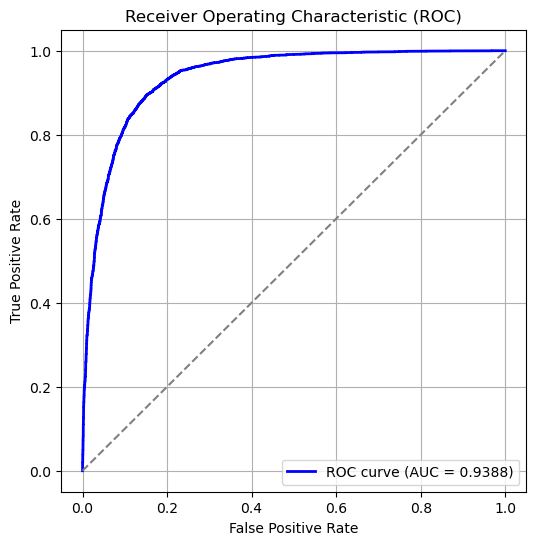

Text: mode mitosis dramatically modified deletion single GENE Aspe...
 True: 0, Prob: 0.9168, Pred@0.5: 1, Pred@0.4: 1

Text: new method monitoring harmonization laboratory results EQA s...
 True: 0, Prob: 0.0205, Pred@0.5: 0, Pred@0.4: 0

Text: DISEASE risks male carriers germline mutations GENE GENE rev...
 True: 1, Prob: 0.9985, Pred@0.5: 1, Pred@0.4: 1

Text: Detection assignment mutations minihaplotypes HOMOSAPIENS DN...
 True: 1, Prob: 0.9286, Pred@0.5: 1, Pred@0.4: 1

Text: Compound K inhibits priming mitochondria associated activati...
 True: 1, Prob: 0.4301, Pred@0.5: 0, Pred@0.4: 1

Text: eDNA eRNA based approach investigate life cycle non cultivab...
 True: 0, Prob: 0.0228, Pred@0.5: 0, Pred@0.4: 0

Text: Membrane Lipids Assist Catalysis DRUG DRUG Cytidylyltransfer...
 True: 0, Prob: 0.3316, Pred@0.5: 0, Pred@0.4: 0

Text: Editorial...
 True: 0, Prob: 0.0027, Pred@0.5: 0, Pred@0.4: 0

Text: GENE promotes DISEASE proliferation invasion attenuates chem...
 True: 0, Prob: 0.953

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# ---------------------------
# Step 1: Split dataset
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    processed_data, labels, test_size=0.2, random_state=42, stratify=labels
)

# ---------------------------
# Step 2: Define pipeline
# ---------------------------
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=1, ngram_range=(1, 2))),
    ('clf', LogisticRegression(
        C=10,
        penalty='l2',
        solver='liblinear',
        random_state=42
    ))
])

# ---------------------------
# Step 3: Cross-validation
# ---------------------------
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(pipeline, processed_data, labels, cv=cv, scoring='accuracy')
print("Cross-validation accuracies:", cv_scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(np.mean(cv_scores), np.std(cv_scores)))

# ---------------------------
# Step 4: Train model
# ---------------------------
pipeline.fit(X_train, y_train)

# Probabilities
y_proba = pipeline.predict_proba(X_test)[:, 1]

# ---------------------------
# Step 5a: Default prediction (cutoff = 0.5)
# ---------------------------
y_pred_default = (y_proba >= 0.5).astype(int)

print("\n=== Default Cutoff (0.5) ===")
print("Classification Report:")
print(classification_report(y_test, y_pred_default))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_default))
print("ROC AUC Score: {:.4f}".format(roc_auc_score(y_test, y_proba)))

# ---------------------------
# Step 5b: Custom cutoff (e.g., 0.3)
# ---------------------------
cutoff = 0.4
y_pred_custom = (y_proba >= cutoff).astype(int)

print(f"\n=== Custom Cutoff ({cutoff}) ===")
print("Classification Report:")
print(classification_report(y_test, y_pred_custom))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))

# ---------------------------
# Step 6: ROC Curve
# ---------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ---------------------------
# Step 7: Show some predictions with probabilities
# ---------------------------
for text, true_label, prob, pred_default, pred_custom in zip(
    X_test[:10], y_test[:10], y_proba[:10], y_pred_default[:10], y_pred_custom[:10]
):
    print(f"Text: {text[:60]}...")
    print(f" True: {true_label}, Prob: {prob:.4f}, "
          f"Pred@0.5: {pred_default}, Pred@{cutoff}: {pred_custom}\n")


In [63]:
tfidf_vectorizer = TfidfVectorizer( ngram_range=(1,2))  # Adjust max_features as needed

vectorised_data  = tfidf_vectorizer.fit_transform(processed_data)


In [12]:
X_train_tfidf

array(<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 235944 stored elements and shape (37921, 20)>, dtype=object)

Original shape: (51823, 2828725)
Reduced shape: (51823, 50)


/home/houcem/miniforge3/envs/data_env/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE output shape: (51823, 2)


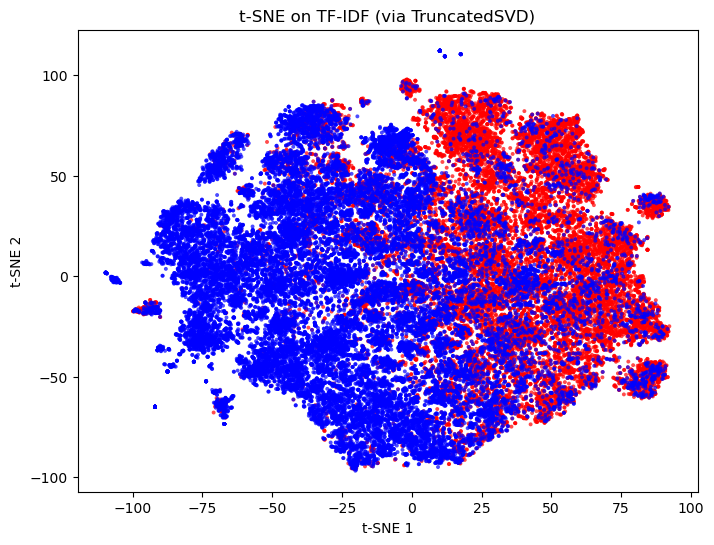

In [76]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# vectorised_data: your TF-IDF sparse matrix (n_samples × n_features)
# labels: list/array of integers for coloring (e.g. 0/1)

# Step 1: Reduce dimensionality with TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=42)  # keep top 50 components
X_reduced = svd.fit_transform(vectorised_data)        # now dense

print("Original shape:", vectorised_data.shape)
print("Reduced shape:", X_reduced.shape)

# Step 2: Apply t-SNE on reduced data
tsne = TSNE(n_components=2, init="pca", perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

print("t-SNE output shape:", X_tsne.shape)

# Step 3: Plot results
plt.figure(figsize=(8, 6))
plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=labels, cmap="bwr", s=8, alpha=0.7, edgecolors="none"
)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE on TF-IDF (via TruncatedSVD)")
plt.show()


In [75]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

# vectorised_data: sparse matrix (n_samples x n_features)
# labels: array/list of 0s and 1s

# Separate indices
class0_idx = np.where(np.array(labels) == 0)[0]
class1_idx = np.where(np.array(labels) == 1)[0]

X0 = vectorised_data[class0_idx]  # negative class
X1 = vectorised_data[class1_idx]  # positive class

# Compute cosine similarity of each class-0 point vs all class-1 points
# Result: shape = (len(X0), len(X1))
similarity_matrix = cosine_similarity(X0, X1)

# Define threshold for overlap (0.8 = very similar, tune as needed)
threshold = 0.5

# For each class-0 point, check if it is too similar to any class-1 point
overlap_mask = (similarity_matrix.max(axis=1) < threshold)  # True = keep

# Filter class-0 points
filtered_class0_idx = class0_idx[overlap_mask]

print("Original class 0 points:", len(class0_idx))
print("Remaining class 0 points after removing overlaps:", len(filtered_class0_idx))

# Combine with class-1 points to get the final filtered dataset
filtered_idx = np.concatenate([filtered_class0_idx, class1_idx])
"""
filtered_vectorised_data = vectorised_data[filtered_idx]
filtered_labels = labels[filtered_idx]

print("Filtered dataset shape:", filtered_vectorised_data.shape)
"""


Original class 0 points: 29992
Remaining class 0 points after removing overlaps: 29880


'\nfiltered_vectorised_data = vectorised_data[filtered_idx]\nfiltered_labels = labels[filtered_idx]\n\nprint("Filtered dataset shape:", filtered_vectorised_data.shape)\n'

In [79]:
filtered_vectorised_data = vectorised_data[filtered_idx]
filtered_labels = labels[filtered_idx]
print("Filtered dataset shape:", filtered_vectorised_data.shape)


Filtered dataset shape: (51711, 2828725)


Original shape: (51711, 2828725)
Reduced shape: (51711, 50)


/home/houcem/miniforge3/envs/data_env/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE output shape: (51711, 2)


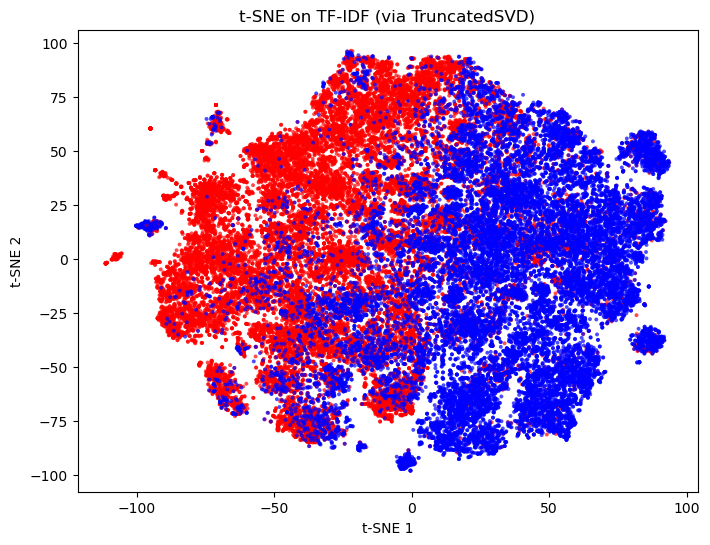

In [80]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# vectorised_data: your TF-IDF sparse matrix (n_samples × n_features)
# labels: list/array of integers for coloring (e.g. 0/1)

# Step 1: Reduce dimensionality with TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=42)  # keep top 50 components
X_reduced = svd.fit_transform(filtered_vectorised_data)        # now dense

print("Original shape:", filtered_vectorised_data.shape)
print("Reduced shape:", X_reduced.shape)

# Step 2: Apply t-SNE on reduced data
tsne = TSNE(n_components=2, init="pca", perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

print("t-SNE output shape:", X_tsne.shape)  

# Step 3: Plot results
plt.figure(figsize=(8, 6))
plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=-filtered_labels, cmap="bwr", s=8, alpha=0.7, edgecolors="none"
)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE on TF-IDF (via TruncatedSVD)")
plt.show()


In [52]:
filtered_labels

array([0, 0, 0, ..., 1, 1, 1], shape=(34616,))

In [4]:
a = np.array([0,1,2,3,4,5,6])
b = np.array([0,1,1,0,0,0,1])

a[b==0]



array([0, 3, 4, 5])